# Indentifying Stress Factors in Rainbow Trouts - ML

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

# https://pmc.ncbi.nlm.nih.gov/articles/PMC11789298/

In [3]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


SEED = 32

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Common Features

In [30]:
commonFeatures = []
with open("./primaryColumnList.txt", "r") as f:
  for line in f:
    commonFeatures.append(str(line.strip()))

In [31]:
observedFeatures = []
with open("./experimentalColumnList.txt", "r") as f:
  for line in f:
    observedFeatures.append(str(line.strip()))

In [32]:
len(observedFeatures)

234

## USDA Data

In [33]:
%%time
dataPath = './data/TPM_stress_USDA.xlsx'
columns = ['GeneExp']+[f"con{i}" for i in range(0,10)]+[f"cro{i}" for i in range(0, 6)]+[f"hs{i}" for i in range(0, 6)]+[f"ht{i}" for i in range(0, 6)]+[f"lt{i}" for i in range(0, 6)]+[f"rw{i}" for i in range(0, 6)]

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]

colDefMap = {'con':"Control", 'cro':"Crowded", "hs": "High Salinity", "ht": "High Temp", "lt": "Low Temp", 'rw': "Reu"}

# data = pd.read_excel(dataPath, nrows = 1000)
dataUSDA = pd.read_excel(dataPath)

dataUSDA.columns = columns
dataUSDA = dataUSDA.set_index('GeneExp').T

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]
dataUSDA = dataUSDA.assign(tank = tankColums)

print(dataUSDA.shape)
dataUSDA.head()

(40, 125909)
CPU times: user 21.2 s, sys: 261 ms, total: 21.5 s
Wall time: 21.6 s


GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


## UMD Data

In [9]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
dataUMD = pd.read_excel(dataPath)

colsTemp = ['idx']+['CTRL']*(dataUMD.shape[1]//2)+['HEAT']*(dataUMD.shape[1]//2)

dataUMD.columns = colsTemp
dataUMD.iloc[0,0] = 'DAY'

dataUMD = dataUMD.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)
dataUMD.rename(columns={'GeneExp':'Group'}, inplace=True)
print(dataUMD.shape)

(72, 125910)
CPU times: user 38.2 s, sys: 454 ms, total: 38.7 s
Wall time: 38.7 s


## Primary Features

In [10]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

commonFeaturesUMD = list(set(umdDataFeatures) & set(commonFeatures))

print(f"{len(commonFeatures)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(commonFeaturesUMD)*100/len(commonFeatures):.2f}% of the training data feature set (USDA)")

54.86% of UMD data feature set
71.48% of the training data feature set (USDA)
CPU times: user 9.62 ms, sys: 593 µs, total: 10.2 ms
Wall time: 10.2 ms


## Merging UMD & USDA data

In [11]:
dataModelUSDA = dataUSDA.loc[:,commonFeaturesUMD+['tank']].copy().reset_index(drop=True)
dataModelUSDA = dataModelUSDA[(dataModelUSDA['tank'] == 'con') | (dataModelUSDA['tank'] == 'ht')]
dataModelUSDA.loc[:,:] = dataModelUSDA.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})

dataModelUSDA = dataModelUSDA.assign(src='usda')
dataModelUSDA.head()

GeneExp,LOC110504514_7,arid4b_6,LOC110534265_1,LOC110508340_1,LOC118936313_3,LOC110532911_1,LOC110519559_1,slc14a2_2,camkva_3,snf8_2,...,LOC110501285_2,LOC110485687_3,LOC110487144_4,adgrf8_25,zbtb14_3,LOC110535945_3,si:ch211-266g18.10_48,LOC110526423_1,tank,src
0,3.292721,0.225667,0.372956,0.602493,0.918833,0.808910,0.578241,8.473162,0.456196,18.840668,...,1.377547,1.748346,0.006359,1.332214,8.402817,5.315495,0.001957,0.863879,0,usda
1,2.825189,0.204219,0.499244,0.822087,0.893428,0.780005,1.517958,7.986385,0.536121,19.755101,...,1.645004,2.951684,0.009658,1.134441,7.651729,5.026063,0.003716,0.690050,0,usda
2,2.921300,0.251836,0.431755,0.881538,1.161702,0.793638,2.696791,7.084284,0.672023,17.744348,...,1.411818,2.309814,0.012761,0.902993,9.881352,4.324554,0.000000,0.686754,0,usda
3,2.887163,0.219658,0.292375,0.809005,1.185163,0.796489,3.098292,6.731739,0.718021,16.745000,...,1.321882,3.319466,0.018918,0.910562,9.596531,4.848393,0.003235,0.787950,0,usda
4,1.271525,0.267954,0.450289,0.735184,0.707783,0.797338,2.988381,7.072490,1.047842,11.007553,...,1.275850,2.115194,0.010225,1.019994,9.022616,3.334061,0.000000,0.542147,0,usda


In [12]:
dataModelUMD = dataUMD.loc[:, commonFeaturesUMD+['Group']]
dataModelUMD.rename(columns={'Group':'tank'},inplace=True)
dataModelUMD.loc[:,:] = dataModelUMD.replace({'tank':{'CTRL':0, "HEAT": 1}})

dataModelUMD = dataModelUMD.assign(src='umd')
dataModelUMD.head()

idx,LOC110504514_7,arid4b_6,LOC110534265_1,LOC110508340_1,LOC118936313_3,LOC110532911_1,LOC110519559_1,slc14a2_2,camkva_3,snf8_2,...,LOC110501285_2,LOC110485687_3,LOC110487144_4,adgrf8_25,zbtb14_3,LOC110535945_3,si:ch211-266g18.10_48,LOC110526423_1,tank,src
0,1.486243,0.184865,0.21966,1.801976,0.171589,0.305462,0,7.555576,0,22.592366,...,0.765533,0,0.053561,0.818538,6.146023,2.817601,0.007493,0.415658,0,umd
1,1.682288,0.291851,0.421598,0.574654,0.399001,0.685807,0,14.015109,0.257847,19.270274,...,0.753488,0,0.056074,1.366523,3.706821,2.9466,0.009956,0.7124,0,umd
2,1.972833,0.197838,0.39571,0.738083,0.390457,0.47338,0,6.915975,0,18.54806,...,0.774221,0,0.03878,0.788029,2.082946,1.825511,0.004262,0.33927,0,umd
3,1.290597,0.365823,0.337711,1.052755,0.69249,0.681497,0,9.49817,0.031965,23.048635,...,0.719248,0,0.041173,1.048703,3.719314,3.730211,0.00576,0.715452,0,umd
4,0.763609,0.185754,0.360848,0.631512,0.704699,0.524231,0,20.468908,0,15.882692,...,0.248412,0.130564,0.053326,1.187593,4.200883,2.657183,0.005471,0.44862,0,umd


In [13]:
dataModel = pd.concat([dataModelUMD, dataModelUSDA],axis=0).sample(frac=1)
dataModel = dataModel.assign(strat = dataModel[['tank', 'src']].apply(lambda row: f"{row['tank']}_{row['src']}", axis=1))
print(dataModel.shape)
dataModel.head()

(88, 49381)


,LOC110504514_7,arid4b_6,LOC110534265_1,LOC110508340_1,LOC118936313_3,LOC110532911_1,LOC110519559_1,slc14a2_2,camkva_3,snf8_2,...,LOC110485687_3,LOC110487144_4,adgrf8_25,zbtb14_3,LOC110535945_3,si:ch211-266g18.10_48,LOC110526423_1,tank,src,strat
50,2.85439,0.223838,0.438935,0.345677,0.797191,0.533565,0,11.442645,0,25.610216,...,0,0.02919,1.918737,5.487387,1.571784,0.015721,0.633775,1,umd,1_umd
64,1.467288,0.163931,0.481426,1.024701,0.838533,0.555298,0,12.45745,0.147787,21.349962,...,0,0.020767,1.521712,5.577064,3.337999,0.015978,0.513838,1,umd,1_umd
9,3.835893,0.207976,0.381863,0.831808,1.018648,0.631931,1.235868,6.026355,0.664434,21.986552,...,1.42871,0.029177,1.048016,6.61671,3.908142,0.009977,0.806149,0,usda,0_usda
2,1.972833,0.197838,0.39571,0.738083,0.390457,0.47338,0,6.915975,0,18.54806,...,0,0.03878,0.788029,2.082946,1.825511,0.004262,0.33927,0,umd,0_umd
41,2.255714,0.286976,0.35875,0.898953,0.840722,0.691243,0,8.249048,0,17.697988,...,0.500675,0.047715,1.533163,2.446335,1.568772,0.01335,0.531279,1,umd,1_umd


In [14]:
dataModel['strat'].value_counts()

strat
1_umd     36
0_umd     36
0_usda    10
1_usda     6
Name: count, dtype: int64

# Models

In [15]:
def resultAnalysisFnx(ytrue,ypred,target_names=None):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(4, 2))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black', xticklabels=True, yticklabels=True)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

In [16]:
%%time
# xdata, ydata = dataModel.iloc[:,:-3], dataModel.iloc[:,-3]
# ydata = np.array(ydata.astype(int))

xdata, ydata = dataModel.iloc[:,:-3], dataModel.iloc[:,-3:-1]
ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 364 ms, sys: 14.5 ms, total: 378 ms
Wall time: 378 ms


## Mutual Information

In [17]:
%%time
# Mutual Information
mi = mutual_info_classif(xdata, ydata.iloc[:,0].astype(int), n_jobs=-1)

CPU times: user 1.55 s, sys: 135 ms, total: 1.69 s
Wall time: 5.65 s


In [18]:
featureScoresMI = pd.DataFrame({"feature":xdata.columns, "score":mi})
featureScoresMI.sort_values(by='score', ascending=False, inplace=True)

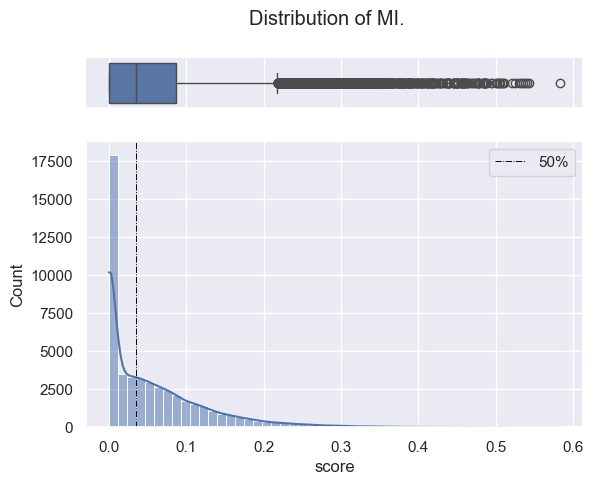

In [26]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(featureScoresMI['score'], ax=ax_box, orient='h')
sns.histplot(featureScoresMI['score'],bins=50, kde=True, ax=ax_hist)
ax_hist.axvline(0.035026,c='black',ls='-.', lw=0.7, label='50%')
plt.legend()

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Distribution of MI.")
plt.show()

In [22]:
featureScoresMI.describe()

,score
count,49378.000000
mean,0.056887
std,0.069136
min,0.000000
25%,0.000000
50%,0.035026
75%,0.087181
max,0.582920


In [21]:
featureScoresMI[featureScoresMI['score']!=0]

,feature,score
37153,LOC110533950_2,5.829199e-01
33231,LOC110522488_3,5.424439e-01
11364,LOC118936524_2,5.407721e-01
3700,hsp47_1,5.379940e-01
11112,LOC118938279_1,5.353057e-01
...,...,...
47344,LOC110525767_1,2.282445e-05
5913,LOC110507300_1,1.405796e-05
8926,LOC110524273_1,1.364802e-05
47879,LOC110512327_2,4.786931e-06


## Logistic Regression

In [63]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrain, ytrain.iloc[:,0].astype(int))

CPU times: user 31.1 s, sys: 8.94 s, total: 40.1 s
Wall time: 5.12 s


LogisticRegression(random_state=32)

In [64]:
%%time
ypred = logRes_clf.predict(xstest)

CPU times: user 64.3 ms, sys: 143 ms, total: 207 ms
Wall time: 28.8 ms


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        13

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



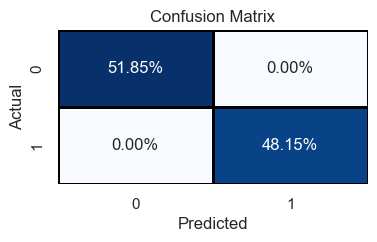

In [65]:
_ = resultAnalysisFnx(ytest.iloc[:,0].astype(int), ypred, target_names=None)

In [66]:
importances = logRes_clf.coef_[0]

49376


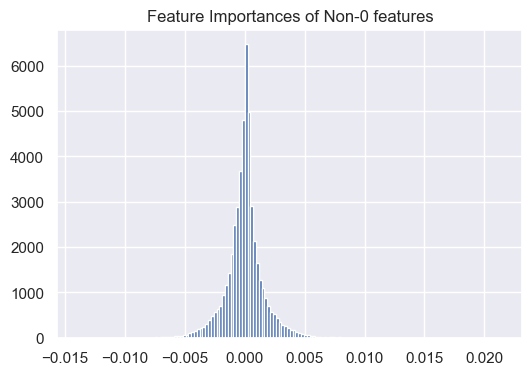

In [73]:
print(len(importances[importances!=0]))

plt.figure(figsize=(6,4), dpi = 100)
plt.hist(importances[importances!=0], bins = 150)
# plt.hist(importances, bins = 150)
plt.title("Feature Importances of Non-0 features")
plt.show()

## Decision Trees

In [83]:
%%time
dt_clf = DecisionTreeClassifier()

dt_clf.fit(xstrain, ytrain.iloc[:,0].astype(int))

CPU times: user 244 ms, sys: 3.55 ms, total: 248 ms
Wall time: 246 ms


DecisionTreeClassifier()

In [84]:
%%time
ypred = dt_clf.predict(xstest)

CPU times: user 1.32 ms, sys: 1.45 ms, total: 2.76 ms
Wall time: 1.5 ms


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.92      0.92      0.92        13

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.93      0.93      0.93        27



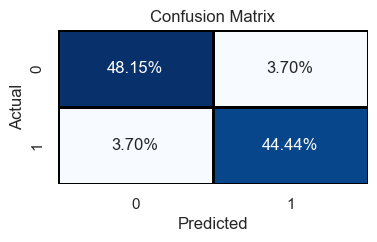

In [85]:
_ = resultAnalysisFnx(ytest.iloc[:,0].astype(int), ypred, target_names=None)

In [86]:
importance = dt_clf.feature_importances_
for i,j in zip(xdata.columns, importance):
    if j != 0:
        print(i, j)

LOC110522488_3 0.9364583333333333
LOC110500835_2 0.06354166666666664


## Recursive Feature Elimination 

In [116]:
%%time
# logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet',solver='saga',C=0.21, l1_ratio=0.5)
logRes_clf = LogisticRegression(random_state=SEED)
selector = RFE(logRes_clf, n_features_to_select=100, step=0.05, verbose = 0)

selector.fit(xstrain, ytrain.iloc[:,0].astype(int))

Fitting estimator with 49378 features.
Fitting estimator with 46910 features.
Fitting estimator with 44442 features.
Fitting estimator with 41974 features.
Fitting estimator with 39506 features.
Fitting estimator with 37038 features.
Fitting estimator with 34570 features.
Fitting estimator with 32102 features.
Fitting estimator with 29634 features.
Fitting estimator with 27166 features.
Fitting estimator with 24698 features.
Fitting estimator with 22230 features.
Fitting estimator with 19762 features.
Fitting estimator with 17294 features.
Fitting estimator with 14826 features.
Fitting estimator with 12358 features.
Fitting estimator with 9890 features.
Fitting estimator with 7422 features.
Fitting estimator with 4954 features.
Fitting estimator with 2486 features.
CPU times: user 8min 8s, sys: 2min 25s, total: 10min 34s
Wall time: 1min 22s


RFE(estimator=LogisticRegression(random_state=32), n_features_to_select=100,
    step=0.05, verbose=1)

---

# Observed Features

In [35]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

observedFeaturesUMD = list(set(umdDataFeatures) & set(observedFeatures))

print(f"{len(observedFeaturesUMD)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(observedFeaturesUMD)*100/len(observedFeatures):.2f}% of the training data feature set (USDA)")

0.19% of UMD data feature set
100.00% of the training data feature set (USDA)
CPU times: user 17.4 ms, sys: 2.3 ms, total: 19.7 ms
Wall time: 19.8 ms


In [36]:
EXP_COLUMNS = observedFeaturesUMD

dataModelUSDA = dataUSDA.loc[:,EXP_COLUMNS+['tank']].copy().reset_index(drop=True)
dataModelUSDA = dataModelUSDA[(dataModelUSDA['tank'] == 'con') | (dataModelUSDA['tank'] == 'ht')]
dataModelUSDA.loc[:,:] = dataModelUSDA.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})

dataModelUSDA = dataModelUSDA.assign(src='usda')

dataModelUMD = dataUMD.loc[:, EXP_COLUMNS+['Group']]
dataModelUMD.rename(columns={'Group':'tank'},inplace=True)
dataModelUMD.loc[:,:] = dataModelUMD.replace({'tank':{'CTRL':0, "HEAT": 1}})

dataModelUMD = dataModelUMD.assign(src='umd')

dataModel = pd.concat([dataModelUMD, dataModelUSDA],axis=0).sample(frac=1)
dataModel = dataModel.assign(strat = dataModel[['tank', 'src']].apply(lambda row: f"{row['tank']}_{row['src']}", axis=1))
print(dataModel.shape)
dataModel.head()

(88, 237)


,LOC110528260_3,cdon_2,LOC110500224_1,LOC110535288_1,LOC110528269_2,LOC110524344_2,hyou1_2,LOC100136252_1,LOC110530761_5,LOC110492082_13,...,LOC110533369_1,LOC110521902_2,LOC110487416_5,LOC110485460_2,LOC110521287_1,sb:cb288_3,brdt_8,tank,src,strat
32,2.6741,0.775561,8.816949,0,2.120076,2.508986,1.722653,1.08837,1.335551,0,...,0.849765,1.160817,0.219543,0.703246,2.036037,0,0,0,umd,0_umd
27,1.41309,0.719371,12.950278,0.293175,1.465713,2.870758,5.277298,0.747583,1.316134,0,...,0.843107,2.21215,0.583887,0.49423,0,16.84894,0,0,umd,0_umd
69,1.173267,0.618896,26.303166,0,3.151374,4.50254,13.372162,1.545284,2.073453,33.158977,...,5.628872,6.183082,0.183045,4.852423,0,15.882088,1.930111,1,umd,1_umd
17,0.662156,0.630999,3.28199,0,1.0276,1.229181,1.613912,2.260423,0.456832,0,...,1.290559,0.824149,0,0.543908,4.549693,2.396374,0.580362,0,umd,0_umd
46,2.381342,3.109149,27.147303,0,3.310647,7.597837,9.584546,4.239285,2.094731,0,...,3.287587,7.393706,0.645357,2.867438,0.122174,16.697746,1.356669,1,umd,1_umd


In [37]:
%%time
EXP_COLS = observedFeaturesUMD

xdataEXP, ydataEXP = dataModel.loc[:,EXP_COLS], dataModel.iloc[:,-3:-1]
# ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdataEXP_sca = sca.fit_transform(xdataEXP)

xstrainEXP, xstestEXP, ytrainEXP, ytestEXP = train_test_split(xdataEXP_sca, ydataEXP, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 16.8 ms, sys: 2.26 ms, total: 19 ms
Wall time: 17.1 ms


### LogRes

In [38]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 109 ms, sys: 22 ms, total: 131 ms
Wall time: 29.1 ms


LogisticRegression(random_state=32)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.85      0.92        13

    accuracy                           0.93        27
   macro avg       0.94      0.92      0.93        27
weighted avg       0.94      0.93      0.93        27



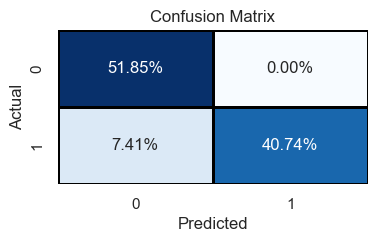

CPU times: user 109 ms, sys: 43.1 ms, total: 152 ms
Wall time: 46.9 ms


In [39]:
%%time
ypredEXP = logRes_clf.predict(xstestEXP)

_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

### Decision Tree

In [40]:
%%time
dt_clf = DecisionTreeClassifier()
dt_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 5.87 ms, sys: 2.17 ms, total: 8.04 ms
Wall time: 5.7 ms


DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.93      1.00      0.96        13

    accuracy                           0.96        27
   macro avg       0.96      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27



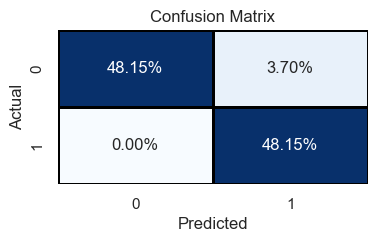

CPU times: user 106 ms, sys: 7.95 ms, total: 114 ms
Wall time: 67.7 ms


In [41]:
%%time
ypredEXP = dt_clf.predict(xstestEXP)

_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

In [42]:
importance = dt_clf.feature_importances_
for i,j in zip(xdata.columns, importance):
    if j != 0:
        print(i, j)

LOC110530407_5 0.06374085684430508
LOC110499362_1 0.9362591431556949


# Experimental Section
**CAUTION:** Section is extremely experimental.

In [43]:
%%time
EXP_COLS = ['LOC110533950_2', 'LOC110522187_1']
EXP_COLS = observedFeaturesUMD

xdataEXP, ydataEXP = dataModel.loc[:,EXP_COLS], dataModel.iloc[:,-3:-1]
# ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdataEXP_sca = sca.fit_transform(xdataEXP)

xstrainEXP, xstestEXP, ytrainEXP, ytestEXP = train_test_split(xdataEXP_sca, ydataEXP, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 15.8 ms, sys: 2.27 ms, total: 18 ms
Wall time: 15.9 ms


In [44]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 62.1 ms, sys: 2.06 ms, total: 64.1 ms
Wall time: 20.3 ms


LogisticRegression(random_state=32)

In [45]:
%%time
ypredEXP = logRes_clf.predict(xstestEXP)

CPU times: user 171 µs, sys: 20 µs, total: 191 µs
Wall time: 194 µs


              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.85      0.92        13

    accuracy                           0.93        27
   macro avg       0.94      0.92      0.93        27
weighted avg       0.94      0.93      0.93        27



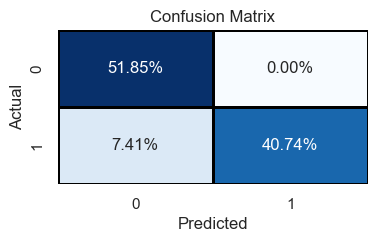

In [46]:
_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

## Isolated Datsets

In [47]:
%%time
xtrainEXPv2, ytrainEXPv2 = dataModelUSDA.loc[:,EXP_COLS], dataModelUSDA.iloc[:,-2]

xtestEXPv2, ytestEXPv2 = dataModelUMD.loc[:,EXP_COLS], dataModelUMD.iloc[:,-2]

xtrainEXPv2, ytrainEXPv2 = shuffle(xtrainEXPv2, ytrainEXPv2, random_state=SEED)
xtestEXPv2, ytestEXPv2 = shuffle(xtestEXPv2, ytestEXPv2 , random_state=SEED)

sca = StandardScaler()

xtrainEXPv2_sca = sca.fit_transform(xtrainEXPv2)
xtestEXPv2_sca = sca.transform(xtestEXPv2)

CPU times: user 16.4 ms, sys: 2.66 ms, total: 19.1 ms
Wall time: 16.5 ms


In [48]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xtrainEXPv2_sca, ytrainEXPv2.astype(int))

CPU times: user 8.89 ms, sys: 3.66 ms, total: 12.6 ms
Wall time: 9.22 ms


LogisticRegression(random_state=32)

In [49]:
%%time
ypredEXPv2 = logRes_clf.predict(xtestEXPv2)

CPU times: user 93.7 ms, sys: 1.43 ms, total: 95.1 ms
Wall time: 26.9 ms


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        36
           1       0.00      0.00      0.00        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72



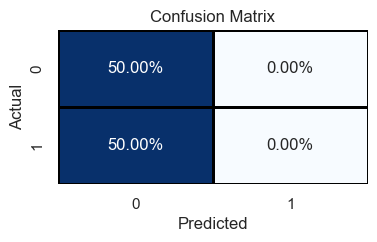

In [50]:
_ = resultAnalysisFnx(ytestEXPv2.astype(int), ypredEXPv2, target_names=None)

## Statstical Variation

In [53]:
dataModelExp_temp = dataModel[EXP_COLS+['tank', 'src']]

In [55]:
# # transcript = 'LOC110522187_1'
# # transcript = 'LOC110533950_2'

# plt.figure(figsize=(8,5), dpi = 80)
# sns.histplot(data = dataModelExp_temp, x=transcript, hue='src', binwidth=2)
# plt.show()

In [56]:
# plt.figure(figsize=(8,5), dpi = 80)
# sns.boxplot(data = dataModelExp_temp, y=transcript, hue='src', orient='h')
# plt.show()